<h1><center> Predictive statistics on the I-SPY1 Clinical Trial</center></h1>

### 0. Load modules and clean data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# import custom modules wrote by julio
from ispy1 import predictive_statistics

# reload modules without restartign the kernel (makes development easier)
import importlib
importlib.reload(predictive_statistics);

In [18]:
df = pd.read_csv('./data/I-SPY_1_clean_data.csv')
df.head(2)

,SUBJECTID,age,White,ER+,PR+,HR+,Bilateral,Right_Breast,MRI_LD_Baseline,MRI_LD_1_3dAC,MRI_LD_Int_Reg,MRI_LD_PreSurg,Alive,Survival_length,RFS,RFS_code,PCR,RCB
0,1001,38.73,Yes,Yes,No,Yes,No,No,88.0,78.0,30.0,14.0,No,1264,751,1,No,2.0
1,1002,37.79,Yes,Yes,Yes,Yes,No,Yes,29.0,26.0,66.0,16.0,No,1155,1043,1,No,3.0


<h1><center> Prediction of categorical outcomes</center></h1>

## 1.0 Pathological Complete Response (PCR)

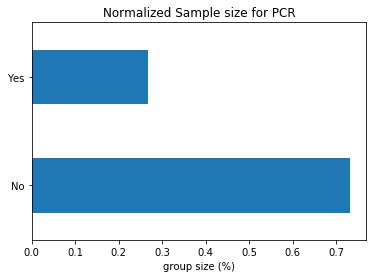

In [61]:
# check how unbalanced the data are
outcome = 'PCR'
df[outcome].value_counts(normalize = True).plot.barh();
plt.title('Normalized Sample size for PCR')
plt.xlabel('group size (%)');
plt.savefig('Sample_Size_PCR.png')

In [20]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
X_cont = df[cont_predictors].values

# allocate clinical predictors
cat_predictors = ['White', 'ER+', 'PR+', 'HR+'];
X_cat = pd.pandas.get_dummies(df[cat_predictors], drop_first=True).values

# allocate a single predictors matrix X
X = np.concatenate( (X_cont, X_cat), axis=1)

# allocate  outcome 
outcome = 'PCR'
y = predictive_statistics.labels_to_numbers(df, outcome);

## Why Kappa is a good metric

In [21]:
from sklearn import metrics

def mymetrics(ypredicted, yexpected):
    print(metrics.classification_report(ypredicted, yexpected))
    k = metrics.cohen_kappa_score(ypredicted, yexpected); k = np.round(k,3);
    auc = metrics.roc_auc_score(ypredicted, yexpected);   auc  = np.round(auc,3);
    accuracy = metrics.accuracy_score(ypredicted, yexpected); accuracy = np.round(accuracy,3);

    print("Kappa = " + str(k))
    print("AUC = " + str(auc))
    print("Accuracy = " + str(accuracy))

# make at least one observation positive
y_crazy = np.zeros_like(y)
y_crazy[np.argwhere(y>0)[0]] = 1
mymetrics(y_crazy, y)

             precision    recall  f1-score   support

          0       1.00      0.74      0.85       167
          1       0.02      1.00      0.04         1

avg / total       0.99      0.74      0.84       168

Kappa = 0.032
AUC = 0.868
Accuracy = 0.738


- ### logistic Regression

             precision    recall  f1-score   support

          0       0.77      0.87      0.82        39
          1       0.29      0.17      0.21        12

avg / total       0.66      0.71      0.68        51

The estimated Cohen kappa is 0.0449438202247
The estimated AUC is 0.519



Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.82      0.72      0.77        39
          1       0.35      0.50      0.41        12

avg / total       0.71      0.67      0.68        51

The estimated Cohen kappa is 0.190476190476
The estimated AUC is 0.609





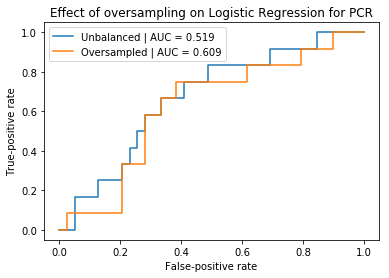

In [45]:
# standard
auc1, kappa1, fpr1, tpr1 = predictive_statistics.Logistic_Regression(X, y, oversample = False)

# oversampled
auc2, kappa2, fpr2, tpr2 = predictive_statistics.Logistic_Regression(X, y, oversample = True, K_neighbors = 4)

title ='Effect of oversampling on Logistic Regression for PCR'
predictive_statistics.plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)
plt.savefig('PCR_Logistic.png')

- ### random forests

             precision    recall  f1-score   support

          0       0.80      0.92      0.86        39
          1       0.50      0.25      0.33        12

avg / total       0.73      0.76      0.73        51

The estimated Cohen kappa is 0.209302325581
The estimated AUC is 0.587





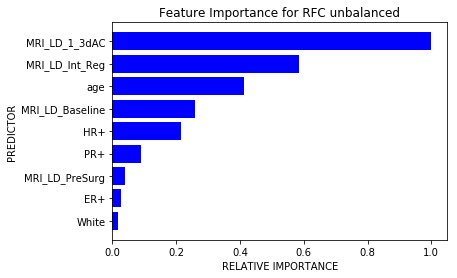

Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.79      0.87      0.83        39
          1       0.38      0.25      0.30        12

avg / total       0.69      0.73      0.70        51

The estimated Cohen kappa is 0.13768115942
The estimated AUC is 0.561





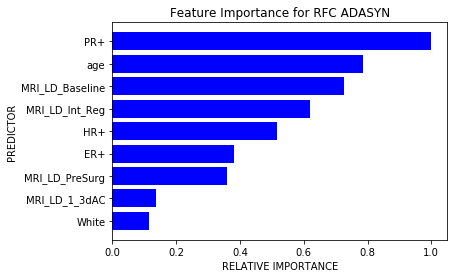

In [43]:
# standard
auc1, kappa1, fpr1, tpr1, forest = predictive_statistics.RandomForest_Classifier(X, y,oversample=False)
t ='Feature Importance for RFC unbalanced'
predictive_statistics.plot_forest_feature_importances_(forest, cont_predictors + cat_predictors, title = t)
plt.savefig('RFC_std_PCR.png')

# unbalanced learning
auc2, kappa2, fpr2, tpr2, Forest = predictive_statistics.RandomForest_Classifier(X, y, oversample=True, K_neighbors = 5)
t ='Feature Importance for RFC ADASYN'
predictive_statistics.plot_forest_feature_importances_(Forest, cont_predictors + cat_predictors, title = t)
plt.savefig('RFC_Adasyn_PCR.png')

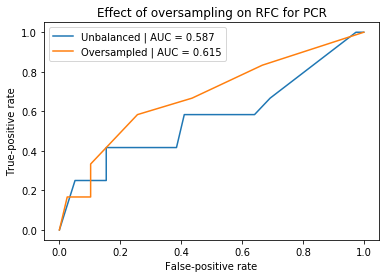

In [41]:
# compare
title ='Effect of oversampling on RFC for PCR'
predictive_statistics.plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)
plt.savefig('RFC_std_PCR.png')

In [56]:
K = [4,5,6]
for k in K:
    predictive_statistics.Logistic_Regression(X, y, oversample=True, K_neighbors = k)


Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.36      0.45      0.40        11
          1       0.84      0.78      0.81        40

avg / total       0.73      0.71      0.72        51

The estimated Cohen kappa is 0.208893485005
The estimated AUC is 0.615



Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.36      0.36      0.36        11
          1       0.82      0.82      0.82        40

avg / total       0.73      0.73      0.73        51

The estimated Cohen kappa is 0.188636363636
The estimated AUC is 0.594



Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.33      0.45      0.38        11
          1       0.83      0.75      0.79        40

avg / total       0.73      0.69      0.70        51

The estimated Cohen kappa is 0.180722891566
The estimated AUC is 0.602



## 2.0 Survival (`Alive`) using Logistic Regression

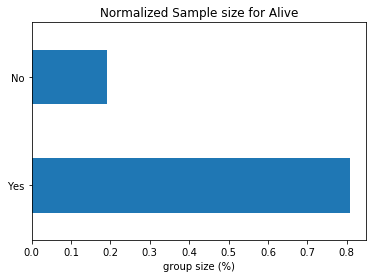

In [46]:
# allocate  outcome 
outcome = 'Alive'
y = predictive_statistics.labels_to_numbers(df, outcome);

# check how unbalanced the data are
df[outcome].value_counts(normalize = True).plot.barh();
plt.title('Normalized Sample size for Alive')
plt.xlabel('group size (%)');
plt.savefig('Sample_Size_Alive.png')

- ### Logistic Regression

In [57]:
# standard
auc1, kappa1, fpr1, tpr1 = predictive_statistics.Logistic_Regression(X, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2 = predictive_statistics.Logistic_Regression(X, y, oversample=True, K_neighbors = 4)

             precision    recall  f1-score   support

          0       0.50      0.27      0.35        11
          1       0.82      0.93      0.87        40

avg / total       0.75      0.78      0.76        51

The estimated Cohen kappa is 0.236734693878
The estimated AUC is 0.599



Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.36      0.45      0.40        11
          1       0.84      0.78      0.81        40

avg / total       0.73      0.71      0.72        51

The estimated Cohen kappa is 0.208893485005
The estimated AUC is 0.615





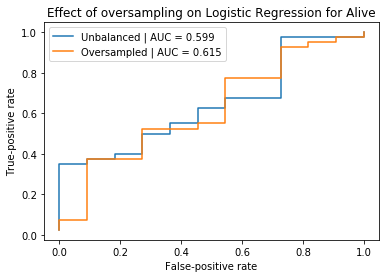

In [58]:
title ='Effect of oversampling on Logistic Regression for Alive'
predictive_statistics.plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)
plt.savefig('Alive_Logistic.png')

- ### random forests

             precision    recall  f1-score   support

          0       0.38      0.27      0.32        11
          1       0.81      0.88      0.84        40

avg / total       0.72      0.75      0.73        51

The estimated Cohen kappa is 0.16393442623
The estimated AUC is 0.574



Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.67      0.36      0.47        11
          1       0.84      0.95      0.89        40

avg / total       0.81      0.82      0.80        51

The estimated Cohen kappa is 0.375510204082
The estimated AUC is 0.657





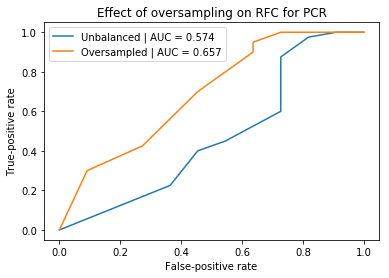

In [59]:
# standard
auc1, kappa1, fpr1, tpr1, _= predictive_statistics.RandomForest_Classifier(X, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2, _= predictive_statistics.RandomForest_Classifier(X, y, oversample=True, K_neighbors = 6)

title ='Effect of oversampling on RFC for PCR'
predictive_statistics.plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)
plt.savefig('Alive_RFC.png')

## 3.0 Survival (`Alive`) including PCR as predictor

In [ ]:
# allocate new predictor variable
pcr = predictive_statistics.labels_to_numbers(df, 'PCR').reshape(168,1)
newX = np.concatenate((X,pcr), axis  = 1)

# standard
auc1, kappa1, fpr1, tpr1 = Logistic_Regression(newX, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2 = Logistic_Regression(newX, y, oversample=True, K_neighbors = 10)

In [ ]:
title ='Effect of oversampling on Logistic Regression for Alive (PCR included)'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

## 4.0 Survival (`Alive`) including `RCB` as predictor

In [ ]:
rcb = pd.get_dummies(df['RCB']).values
newX = np.concatenate((X,rcb), axis  = 1)

# standard
auc1, kappa1, fpr1, tpr1 = Logistic_Regression(newX, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2 = Logistic_Regression(newX, y, oversample=True, K_neighbors = 10)

title ='Effect of oversampling on Logistic Regression for Alive (RCB included)'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

<h1><center> Prediction of continous outcomes</center></h1>

## Prepare functions

In [ ]:
# metrics
mae = metrics.median_absolute_error

def mae_report(Ytest, Yhat, outcome_):
    error = mae(Ytest, Yhat)
    error = np.round( error, decimals=3)
    # report
    print('\n' )
    print('==' *40)
    print('The median absolute error for testing data set of ' + outcome_ + ' is: ' + str(error))
    print('==' *40)

def train_test_report(predictor, Xtrain, Ytrain, Xtest, Ytest, outcome):
    # train
    predictor.fit(Xtrain, Ytrain)
    # test
    Yhat = predictor.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)
    
# lsq 
import statsmodels.api as sm
def lsq(Xtrain,Ytrain, Xtest, Ytest, outcome =''):
    # train
    OLS = sm.OLS(Ytrain,Xtrain).fit();
    print(OLS.summary())
    #test
    Yhat = OLS.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)

# SVR    
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV   

# GridSearchCV utility
def gridsearch(regressor, grid):
    optimized_regressor=  GridSearchCV(  regressor, 
                               param_grid = grid, 
                               cv= 3, verbose = 0, n_jobs = -1,
                               scoring = metrics.make_scorer(metrics.median_absolute_error))
    
    return optimized_regressor
    


def svr(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  SVR()
    # define parameter grid search
    grid = dict(       kernel = ['rbf','linear','sigmoid'], 
                       C = np.arange(1,11,1),
                       epsilon = np.arange(1,11,1),
                       gamma = np.linspace(1/10,10,3))
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)

    
# ElasticNet
from sklearn.linear_model import ElasticNet as ENet

def ElasticNet(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  ENet(max_iter=5000)
    # define parameter grid search
    grid = dict(   alpha = np.arange(1,20,.5), l1_ratio = np.arange(.1,1,.05))
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)
    

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor as RFR

def RandomForestRegressor(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  RFR( criterion='mse', random_state = RANDOM_STATE)
    
    #
    num_features = Xtrain.shape[1]
    
    # define parameter grid search
    grid = dict(    n_estimators = np.arange(5,100,5), 
                    max_features = np.arange(1,num_features, 1),
                    max_depth = [None, 1, 2, 3, 4, 5])
    
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)
    

## Organize predictors in the right format and split data

In [ ]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
contX = df[cont_predictors].values

# allocate categorical predictors
cat_pred = ['PCR','White', 'ER+', 'PR+', 'HR+'];
catX = pd.pandas.get_dummies(df[cat_pred], drop_first=True).values

# concatenate predictors
X = np.concatenate( (catX, contX), axis=1)

#outcome
y = df.RFS.values / 30; # conver to months

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## 1.0 Recurrence-Free Survival (`RFS`, Continous in months)

In [ ]:
# LSQ
lsq(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

### Categorical Predictors only Linear Regression

## ElasticNet

In [ ]:
ElasticNet(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## SVM Regressor

In [ ]:
svr(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## Random Fores regressor

In [ ]:
RandomForestRegressor(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## 2.0  Survival Length (`Survival_length`, Continous, months)

In [ ]:
y = df.Survival_length.values / 30
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [ ]:
# # LSQ
lsq(X_train, y_train, X_test, y_test, outcome ='Survival_length (months)')

In [ ]:
svr(X_train, y_train, X_test, y_test, outcome ='Survival length (months)')

In [ ]:
ElasticNet(X_train, y_train, X_test, y_test, outcome = 'Survival length (months)')